# Introduction
Let the date_block_num be the consecutive month number ranging from January 2013 (is 0) to October 2015 (is 33). Before feeding data into the RNN LSTM algorithm, we need to aggregate the purchase amount by month and then rearrange them in the correct form. Suppose some item's monthly purchases are not consecutive: ..., 5, 6, 10, 11, 12, .... We may assume that the purchases in month 7, 8 , and 9 are zero amount and have to manully fill zeros in these months. Notice that this type of information should be fed into the algorithms. 

Below we start with shop 37 and item 4885, and will apply this method to all shop & item combinations.

In [1]:
import pandas as pd
sales = pd.read_csv("C:/data/sales_train_v2.csv")

In [2]:
temp = pd.DataFrame(list(range(0,34)))
temp.columns = ['month']

data1 = sales.loc[(sales.shop_id==37)&(sales.item_id==4885)]
data2 = data1.groupby(['date_block_num'])['item_cnt_day', 'item_price'].sum()

data2 = data2.rename(columns = {'item_cnt_day': 'item_cnt_month'})
data2['item_price'] = data2.item_price / data2.item_cnt_month 

data3 = data2.reset_index()

temp1 = temp.merge(data3, left_on='month', right_on='date_block_num', how='left')
temp1.head(15)

# drop date_block_num
temp1.drop(columns = ['month', 'date_block_num'], inplace=True)
# fill item_cnt_month = 0 if NaN
temp1['item_cnt_month'].fillna(0, inplace=True)
# fill item_price = median price if NaN
temp1['item_price'].fillna(temp1.item_price.median(), inplace=True)
temp1

,item_cnt_month,item_price
0,3.0,899.000000
1,6.0,749.166667
2,6.0,749.125000
3,3.0,899.000000
4,1.0,899.000000
5,1.0,899.000000
6,1.0,899.000000
7,3.0,899.000000
8,4.0,899.000000
9,0.0,899.000000


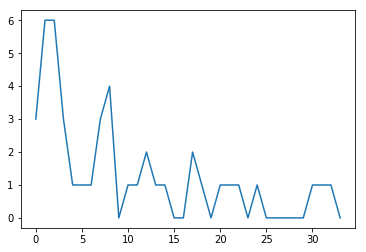

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(temp1['item_cnt_month'])
plt.show()

# RNN LSTM
In the following context, we will reframe time series data into supervised learning and use lag terms in purchase amount as features to fit our model.

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(32, input_shape=(temp1.shape[0],1)))
model.add(Dense(1))

C:\Users\HydeParkPlaces\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
from sklearn import preprocessing
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
values = temp1.values
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, n_in = 3)

reframed1 = pd.DataFrame()
reframed1['x1'] = reframed['var1(t-1)']
reframed1['x2'] = reframed['var1(t-2)']
reframed1['x3'] = reframed['var1(t-3)']
reframed1['y'] = reframed['var1(t)'] 
reframed1

,x1,x2,x3,y
3,1.000000,1.000000,0.500000,0.500000
4,0.500000,1.000000,1.000000,0.166667
5,0.166667,0.500000,1.000000,0.166667
6,0.166667,0.166667,0.500000,0.166667
7,0.166667,0.166667,0.166667,0.500000
8,0.500000,0.166667,0.166667,0.666667
9,0.666667,0.500000,0.166667,0.000000
10,0.000000,0.666667,0.500000,0.166667
11,0.166667,0.000000,0.666667,0.166667
12,0.166667,0.166667,0.000000,0.333333


In [7]:
values = reframed1.values
n_train_hours = 25
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(25, 1, 3) (25,) (6, 1, 3) (6,)


Train on 25 samples, validate on 6 samples
Epoch 1/50
 - 1s - loss: 0.1791 - val_loss: 0.0826
Epoch 2/50
 - 0s - loss: 0.1760 - val_loss: 0.0827
Epoch 3/50
 - 0s - loss: 0.1723 - val_loss: 0.0827
Epoch 4/50
 - 0s - loss: 0.1696 - val_loss: 0.0827
Epoch 5/50
 - 0s - loss: 0.1671 - val_loss: 0.0827
Epoch 6/50
 - 0s - loss: 0.1646 - val_loss: 0.0827
Epoch 7/50
 - 0s - loss: 0.1621 - val_loss: 0.0827
Epoch 8/50
 - 0s - loss: 0.1596 - val_loss: 0.0827
Epoch 9/50
 - 0s - loss: 0.1571 - val_loss: 0.0828
Epoch 10/50
 - 0s - loss: 0.1546 - val_loss: 0.0828
Epoch 11/50
 - 0s - loss: 0.1521 - val_loss: 0.0828
Epoch 12/50
 - 0s - loss: 0.1496 - val_loss: 0.0828
Epoch 13/50
 - 0s - loss: 0.1471 - val_loss: 0.0828
Epoch 14/50
 - 0s - loss: 0.1446 - val_loss: 0.0828
Epoch 15/50
 - 0s - loss: 0.1420 - val_loss: 0.0828
Epoch 16/50
 - 0s - loss: 0.1395 - val_loss: 0.0828
Epoch 17/50
 - 0s - loss: 0.1374 - val_loss: 0.0828
Epoch 18/50
 - 0s - loss: 0.1358 - val_loss: 0.0829
Epoch 19/50
 - 0s - loss: 0.13

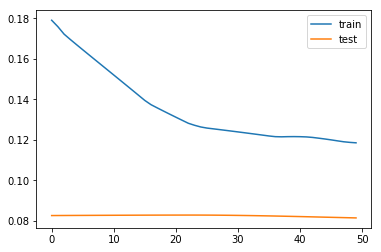

In [8]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1) # what does mean to put test_X[:, 1:] behind?

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(inv_yhat)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)

inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.004
